# DBL Process Mining

## Imports and Class definitions

### Performance Measure

In [1]:
import psutil
p = psutil.Process()
p.cpu_percent(interval=None)
#all of the code you want to check under here
#p.cpu_percent(interval=None) at the end
#multithreading causes over 100% usage


#define global variables
util_counter = 0
memory_stacked = 0
cpu_stacked = 0

memory_initial = round(psutil.virtual_memory()[3]/1024/1024/1024, 3)
memory_initial_perc = psutil.virtual_memory()[2]

cpu_initial_perc = psutil.cpu_percent(4)
# Define function

def reset_mem_report():
    util_counter = 0
    memory_stacked = 0
    cpu_stacked = 0

def mem_report():
    #retrieve global variables (counters and initial values)
    global util_counter
    global memory_stacked
    global cpu_stacked
    
    global memory_initial
    global memory_initial_perc
    
    global cpu_initial_perc
    
    #retrieve current utils
    ram = psutil.virtual_memory()[3]
    ram_perc = psutil.virtual_memory()[2]
    cpu_perc = psutil.cpu_percent(4)
    
    #print RAM usage
    print('Initial RAM memory usage:', memory_initial, 'GB')
    print('Current RAM memory usage:', round(ram/1024/1024/1024, 3), 'GB\n')
    
    print('Initial RAM memory % used:', memory_initial_perc, '%')
    print('Current RAM memory % used:', ram_perc, '%\n')
    
    #add values to sums, and update counter
    util_counter += 1
    memory_stacked += ram_perc
    cpu_stacked += cpu_perc
    
    print('Averaged RAM memory % used', memory_stacked/util_counter, '%\n')
    
    #print CPU usage
    print('Initial CPU % used: ', cpu_initial_perc, '%')
    print('Current CPU % used: ', cpu_perc, '%\n')
    print('Averaged CPU % used', cpu_stacked/util_counter, '%')  

### Imports

In [2]:
import os
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from Utils.LogFile import LogFile 
import tensorflow as tf
import multiprocessing as mp
import copy
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


In [3]:
tf.config.list_physical_devices('GPU')

[]

## Loading in the data

### Two different methods: 
- One csv file, which still has to be split into training and test data
- Two csv files, which are already split into training and test data

In [4]:
# Define attribute columns here
case_attr = "Case ID"
act_attr = "concept:name"
time_attr = "Complete Timestamp"
path = "data/BPI_Challenge_2012_end.csv"
time_format = '%Y-%m-%d %H:%M:%S.%f'
cycle_attr = 'lifecycle:transition' # Optional


In [5]:

logfile = LogFile(path, ",", 0, None, time_attr=time_attr, trace_attr=case_attr,
                   activity_attr=act_attr, time_format=time_format, cycle_attr=cycle_attr, convert=False, k=20)
# logfile = logfile.create_subset(60)
#logfile.add_end_events


In [6]:
len(logfile.data) / len(logfile.data[logfile.trace].unique())

21.035149384885763

In [7]:
logfile.data

,Case ID,Activity,Resource,Complete Timestamp,Variant,Variant index,lifecycle:transition,concept:name,AMOUNT_REQ
0,173688,A_SUBMITTED-COMPLETE,112,2011-10-01 00:38:44.546,Variant 613,613,COMPLETE,A_SUBMITTED,20000
1,173688,A_PARTLYSUBMITTED-COMPLETE,112,2011-10-01 00:38:44.880,Variant 613,613,COMPLETE,A_PARTLYSUBMITTED,20000
2,173688,A_PREACCEPTED-COMPLETE,112,2011-10-01 00:39:37.906,Variant 613,613,COMPLETE,A_PREACCEPTED,20000
3,173688,W_Completeren aanvraag-SCHEDULE,112,2011-10-01 00:39:38.875,Variant 613,613,SCHEDULE,W_Completeren aanvraag,20000
4,173688,W_Completeren aanvraag-START,NaN,2011-10-01 11:36:46.437,Variant 613,613,START,W_Completeren aanvraag,20000
...,...,...,...,...,...,...,...,...,...
275282,214376,W_Afhandelen leads-SCHEDULE,112,2012-02-29 23:52:01.287,Variant 2,2,SCHEDULE,W_Afhandelen leads,15000
275283,214376,W_Afhandelen leads-START,11169,2012-03-01 09:26:46.736,Variant 2,2,START,W_Afhandelen leads,15000
275284,214376,A_DECLINED-COMPLETE,11169,2012-03-01 09:27:37.118,Variant 2,2,COMPLETE,A_DECLINED,15000
275285,214376,W_Afhandelen leads-COMPLETE,11169,2012-03-01 09:27:41.325,Variant 2,2,COMPLETE,W_Afhandelen leads,15000


## Visualization

In [8]:
split_log = logfile.create_split_df()
split_train, split_test = split_log.split_train_test(range(67, 73), type='normal')

Train data lost due to overlap: 0.04500106134578646/n Best Split: 71


C:\Users\20203527\Documents\GitHub\Process-Mining\Utils\LogFile.py:382: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_data[self.time] = pd.to_datetime(split_data[self.time])


In [9]:
split_date = split_train.data['Complete Timestamp'].max()
split_case = split_train.data['Case ID'].max()

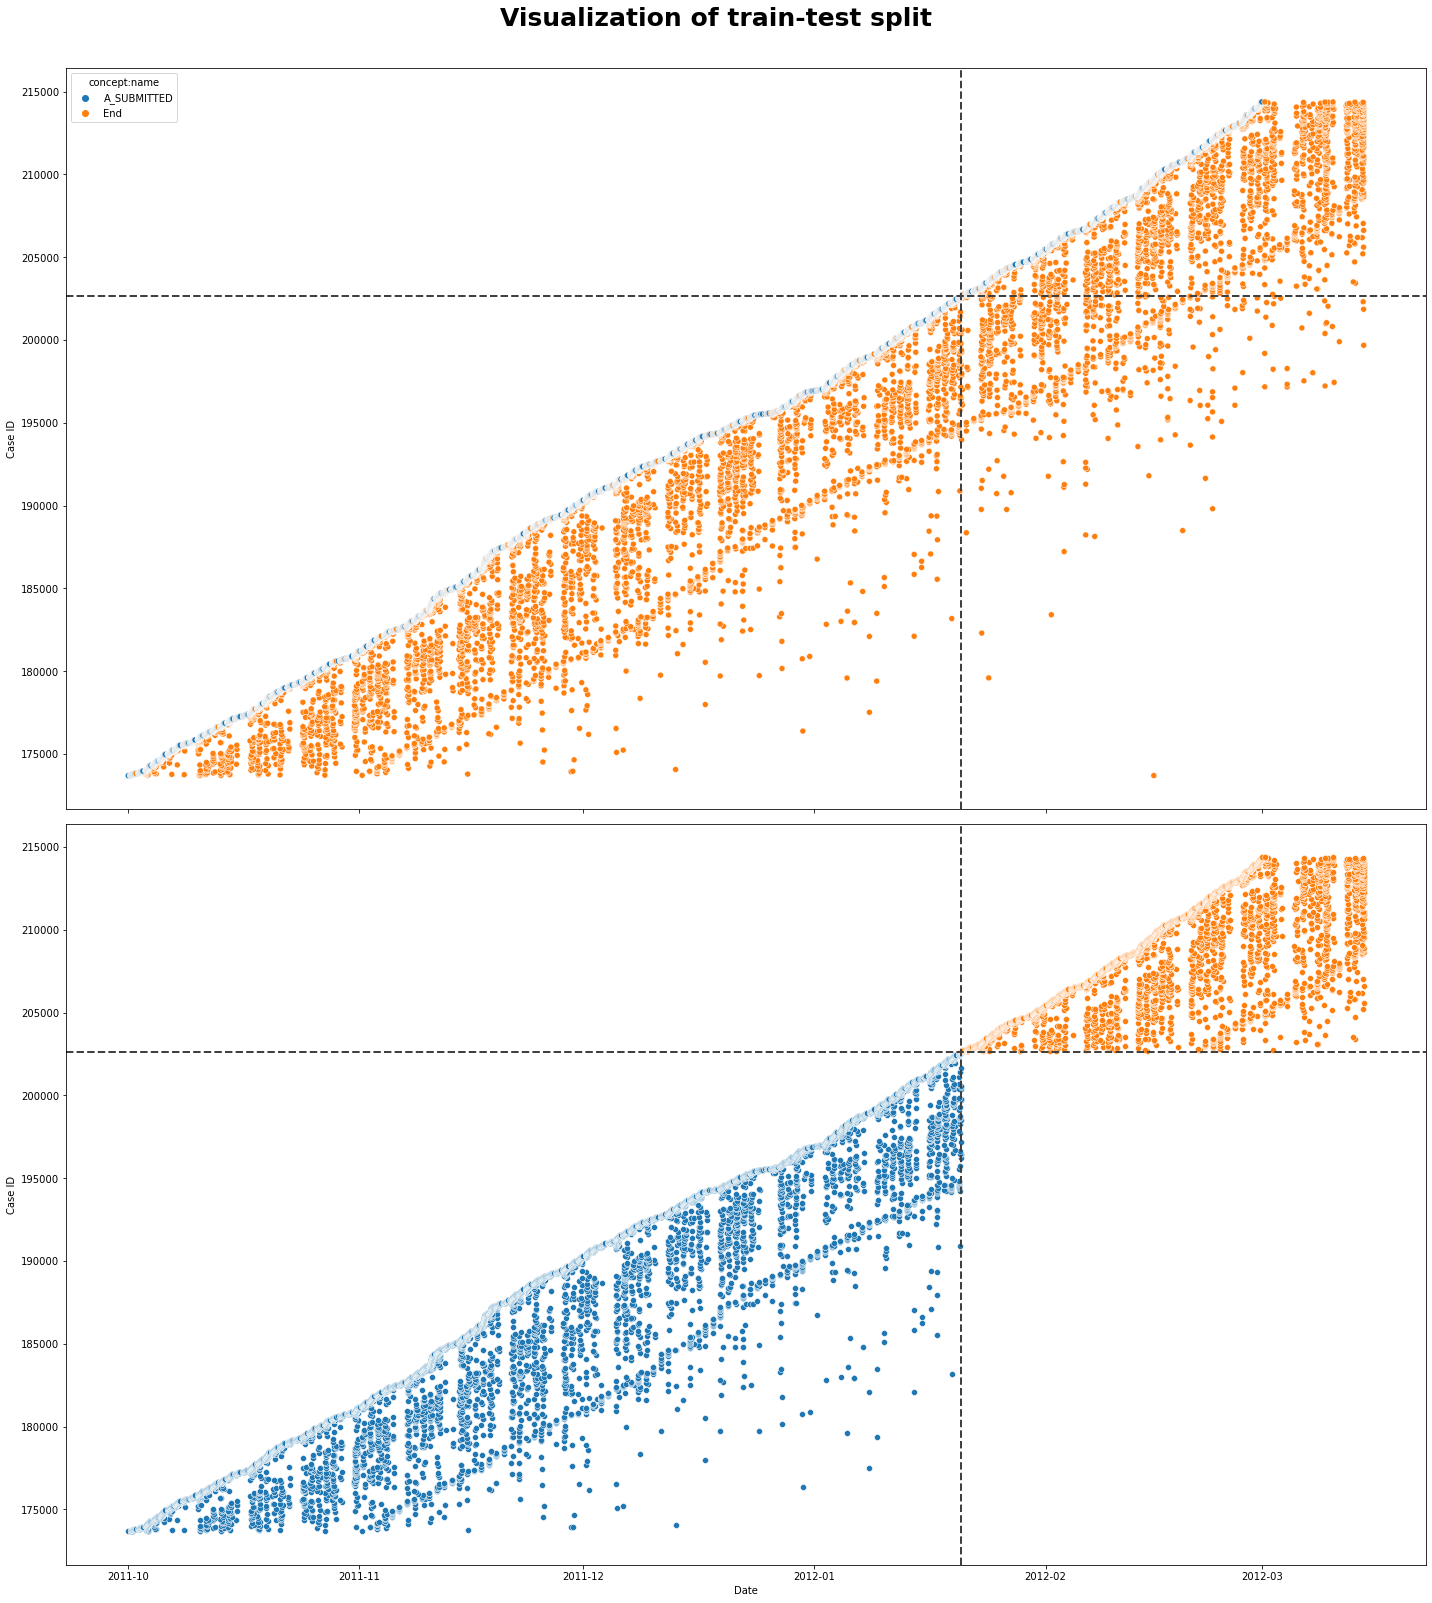

In [10]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 22))

sns.scatterplot(data=split_log.data, x=split_log.time, y=split_log.trace, hue=split_log.activity, ax=ax[0])
sns.scatterplot(data=split_train.data, x=split_log.time, y=split_log.trace, ax=ax[1])
sns.scatterplot(data=split_test.data, x=split_log.time, y=split_log.trace, ax=ax[1])

fig.suptitle('Visualization of train-test split', size=25, weight='bold', y=1.01)
fig.tight_layout()

ax[0].set_xlabel('')
ax[0].set_ylabel('Case ID')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Case ID')

ax[0].axvline(x=split_date, color = '#404040', linestyle='--', linewidth=2)
ax[0].axhline(y=split_case, color = '#404040', linestyle='--', linewidth=2)
ax[1].axvline(x=split_date, color = '#404040', linestyle='--', linewidth=2)
ax[1].axhline(y=split_case, color = '#404040', linestyle='--', linewidth=2)

plt.show()

#### Preprocessing

In [11]:
logfile.keep_attributes([logfile.trace, logfile.time, logfile.activity, logfile.cycle_attr])
activity_map = logfile.int_convert()
logfile.add_start_date()
logfile.create_k_context()
log_train, log_test = logfile.split_train_test(range(67, 73), type='normal')
p.cpu_percent(interval=None)


C:\Users\20203527\Documents\GitHub\Process-Mining\Utils\LogFile.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.cycle_attr] = self.data[self.cycle_attr].replace(cycle_map)
C:\Users\20203527\Documents\GitHub\Process-Mining\Utils\LogFile.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.activity] = self.data[self.activity].replace(map_to_int)
C:\Users\20203527\Documents\GitHub\Process-Mining\Utils\LogFile.py:137: SettingWithCopyWarning: 
A value is trying to be set on a c

Create k-context: 20


C:\Users\20203527\Documents\GitHub\Process-Mining\Utils\LogFile.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.time] = pd.to_datetime(data[self.time])


Train data lost due to overlap: 0.0832651595267075/n Best Split: 71


59.3

In [12]:
p.cpu_percent(interval=None)


0.0

## Baseline prediction

### Preprocessing

In [13]:
def convert_time(dataset):
    """Adds a new column to a dataset with the converted timestamp to datetime"""

    date_list = []

    for time in dataset[logfile.time]:
        date = datetime.strptime(time, logfile.time_format)
        date_list.append(date)

    dataset['time and date'] = date_list
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.406 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 65.8 %

Averaged RAM memory % used 65.8 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.8 %

Averaged CPU % used 1.8 %


### Add actual next event and time

In [14]:
def add_actual_next(df_case):
    """Adds the actual next activity and time to next event to the final dataframe"""

    # Create a list for all the actual next events for an case
    event_lst = [event for event in df_case[logfile.activity]] # Gets a list of all events for a specific trace
    event_lst = event_lst[1:] # Erase the first activity from the list (thus the second activity becomes first in the list)
    event_lst.append('-') # Append a '-' to the end of the list (the last activity does not have a next activity)
    
    # Create a list for time of the next event
    nexttime_lst1 = [time for time in df_case['time and date']]
    nexttime_lst = nexttime_lst1[1:]
    nexttime_lst.append(nexttime_lst[-1])

    # Create the time difference list
    time_diff = []
    for i in range(len(nexttime_lst)):
        time_diff.append((nexttime_lst[i] - nexttime_lst1[i]).total_seconds())

    # Append columns to the case dataframe
    df_case['Next event'] = event_lst
    df_case['Time to next event'] = time_diff

    trace_len = len(df_case)

    return trace_len
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.412 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 65.9 %

Averaged RAM memory % used 65.85 %

Initial CPU % used:  2.5 %
Current CPU % used:  2.1 %

Averaged CPU % used 1.9500000000000002 %


### Predicted next event and time

In [15]:
def get_position_time(df_case, count_dict, time_dict):
    for index, row in df_case.iterrows():
        
        # Get the amount of times an action occured in a certain position {action : {position_1 : count_1, position_2: count_2}}
        if row[logfile.activity] in count_dict:
            if index in count_dict[row[logfile.activity]]:
                count_dict[row[logfile.activity]][index] += 1
            else:
                count_dict[row[logfile.activity]].update({index: 1})
        else:
            count_dict[row[logfile.activity]] = {index: 1}
        
        # Summation of the times to next action per position (index) {position: {"sum": summation_of_time, "count": amount_of_times_occured (to calculate mean)}}
        if index in time_dict:
            time_dict[index]['sum'] += row['Time to next event']
            time_dict[index]['count'] += 1
        else:
            time_dict[index] = {'sum': row['Time to next event'], 'count': 1}

def get_position_rank(max_trace_len, count_dict):
    pos_rank_dict = {}
    for i in range(max_trace_len):
        init = 0
        task = 0
        for key in count_dict.keys():
            try:
                new = count_dict[key][i]
            except:
                new = 0
            if new > init:
                init = new
                task = key

        pos_rank_dict.update({i: task})
    
    return pos_rank_dict

def get_mean_time(total_time_dict):
    mean_time_dict = {}
    for position in total_time_dict.keys():
        mean_time = total_time_dict[position]['sum'] / total_time_dict[position]['count']
        mean_time_dict[position] = mean_time
    
    return mean_time_dict
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.408 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 65.8 %

Averaged RAM memory % used 65.83333333333333 %

Initial CPU % used:  2.5 %
Current CPU % used:  0.9 %

Averaged CPU % used 1.6000000000000003 %


In [16]:
def create_event_pred(df_case, pos_rank_dict, mean_time_dict):
    
    # Prediction for the action
    pred_act_lst = [pos_rank_dict[i] for i in range(len(df_case))]
    pred_act_lst = pred_act_lst[1:]
    pred_act_lst.append('-')

    # Prediction for time
    pred_time_lst = [mean_time_dict[i] for i in range(len(df_case))]

    df_case['Event prediction'] = pred_act_lst 
    df_case['Time prediction'] = pred_time_lst
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.377 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 65.6 %

Averaged RAM memory % used 65.775 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.4 %

Averaged CPU % used 1.5500000000000003 %


### Training and testing functions

In [17]:
def train_baseline(dataframe, maximum=None):
    """Returns the training dataset with predictions and 2 dictionaries which predict next action and nexttime based on position"""
    
    dataset = dataframe
    convert_time(dataset)

    df_actual = pd.DataFrame()


    # Creating a dataframe with the actual events

    cases = list(dataset[logfile.trace].unique())  
    max_trace_len = 0  
    pos_count_dict = {}
    time_dict = {}
    for case in cases[:maximum]:
        df_case = dataset[dataset[logfile.trace] == case].copy().reset_index(drop=True)
        trace_len = add_actual_next(df_case)
        get_position_time(df_case, pos_count_dict, time_dict)
        df_actual = pd.concat([df_actual, df_case])

        if trace_len > max_trace_len:
            max_trace_len = trace_len
    


    # Creating the predicitions
    df_predicted = pd.DataFrame()
    
    pos_rank_dict = get_position_rank(max_trace_len, pos_count_dict)
    mean_time_dict = get_mean_time(time_dict)

    for case in cases[:maximum]:
        df_case = df_actual[df_actual[logfile.trace] == case].copy().reset_index(drop=True)
        create_event_pred(df_case, pos_rank_dict, mean_time_dict)
        df_predicted = pd.concat([df_predicted,df_case])



    return df_predicted, pos_rank_dict, mean_time_dict
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.377 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 65.6 %

Averaged RAM memory % used 65.74000000000001 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.5 %

Averaged CPU % used 1.5400000000000003 %


In [18]:
def test_baseline(dataframe, train_pos, train_time):
    """Creates the test dataset including the predictions based on the training dataset"""
    
    dataset = dataframe
    convert_time(dataset)

    df_predict = pd.DataFrame()
    cases = list(dataset[logfile.trace].unique())  
    for case in cases:
        df_case = dataset[dataset[logfile.trace] == case].copy().reset_index(drop=True)
        _ = add_actual_next(df_case)
        create_event_pred(df_case, train_pos, train_time)
        df_predict = pd.concat([df_predict, df_case])
    
    return df_predict
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.381 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 65.7 %

Averaged RAM memory % used 65.73333333333333 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.0 %

Averaged CPU % used 1.4500000000000002 %


### Accuracy measurement

In [19]:
def get_accuracy(dataset):
    event_accuracy = np.mean(dataset['Next event'] ==  dataset['Event prediction'])
    time_accuracy = np.mean(abs(dataset['Time to next event'] - dataset['Time prediction'])) / 86400  # Mean Absolute Error in days
    
    return event_accuracy, time_accuracy

def get_sample_weight(dataset):
    sample_dict = {}
    for event in dataset[act_attr]:
        if event in sample_dict:
            sample_dict[event] += 1
        else:
            sample_dict[event] = 1


def get_balanced_accuracy(actual_event, event_pred, actual_time, time_pred):
    event_balanced_accuracy = balanced_accuracy_score(actual_event, event_pred, adjusted=True) #possibly use sample weight
    time_accuracy = np.mean(abs(actual_time - time_pred)) / 86400  # Mean Absolute Error in days
    return event_balanced_accuracy, time_accuracy
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.405 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 65.8 %

Averaged RAM memory % used 65.74285714285715 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.8 %

Averaged CPU % used 1.5000000000000002 %


### Predictions

In [20]:
train_df = log_train.data
test_df = log_test.data
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.393 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 65.7 %

Averaged RAM memory % used 65.73750000000001 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.0 %

Averaged CPU % used 1.4375000000000002 %


In [21]:
train_df, train_pos, train_time = train_baseline(train_df)
test_df = test_baseline(test_df, train_pos, train_time)

mem_report()
reset_mem_report()
p.cpu_percent(interval=None)


C:\Users\20203527\AppData\Local\Temp/ipykernel_29504/2835497474.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['time and date'] = date_list
C:\Users\20203527\AppData\Local\Temp/ipykernel_29504/2835497474.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['time and date'] = date_list


Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.396 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 65.8 %

Averaged RAM memory % used 65.74444444444445 %

Initial CPU % used:  2.5 %
Current CPU % used:  7.3 %

Averaged CPU % used 2.088888888888889 %


80.1

In [22]:
p.cpu_percent(interval=None)

104.2

# Random Forest Classifier

## Random Forest event prediction

In [23]:
df_X = log_train.contextdata.copy()
df_X.loc[df_X['Complete Timestamp_Prev0'] == 0, "Complete Timestamp_Prev0"] = df_X['Start Date']
df_X['Complete Timestamp_Prev0'] = pd.to_datetime(df_X['Complete Timestamp_Prev0'])
df_X['Complete Timestamp'] = pd.to_datetime(df_X['Complete Timestamp'])
df_X['Start Date'] = pd.to_datetime(df_X['Start Date'])
df_X['time_since_start'] = (df_X['Complete Timestamp_Prev0'] - df_X['Start Date']).dt.total_seconds()
df_X['day_previous_event'] = df_X['Complete Timestamp_Prev0'].dt.weekday
df_X['hour_previous_event'] = df_X['Complete Timestamp_Prev0'].dt.hour
df_X['time_to_next_event'] = (df_X['Complete Timestamp'] - df_X['Complete Timestamp_Prev0']).dt.total_seconds()
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.502 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 66.4 %

Averaged RAM memory % used 65.81 %

Initial CPU % used:  2.5 %
Current CPU % used:  2.3 %

Averaged CPU % used 2.1100000000000003 %


In [24]:
df_X_test = log_test.contextdata.copy()
df_X_test.loc[df_X_test['Complete Timestamp_Prev0'] == 0, "Complete Timestamp_Prev0"] = df_X_test['Start Date']
df_X_test['Complete Timestamp_Prev0'] = pd.to_datetime(df_X_test['Complete Timestamp_Prev0'])
df_X_test['Complete Timestamp'] = pd.to_datetime(df_X_test['Complete Timestamp'])
df_X_test['Start Date'] = pd.to_datetime(df_X_test['Start Date'])
df_X_test['time_since_start'] = (df_X_test['Complete Timestamp_Prev0'] - df_X_test['Start Date']).dt.total_seconds()
df_X_test['day_previous_event'] = df_X_test['Complete Timestamp_Prev0'].dt.weekday
df_X_test['hour_previous_event'] = df_X_test['Complete Timestamp_Prev0'].dt.hour
df_X_test['time_to_next_event'] = (df_X_test['Complete Timestamp'] - df_X_test['Complete Timestamp_Prev0']).dt.total_seconds()
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 10.54 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 66.7 %

Averaged RAM memory % used 65.89090909090909 %

Initial CPU % used:  2.5 %
Current CPU % used:  7.6 %

Averaged CPU % used 2.6090909090909093 %


In [25]:
y = df_X[logfile.activity]
columns = ['time_since_start', 'day_previous_event', 'hour_previous_event']
columns.extend(["%s_Prev%i" % (logfile.activity, i) for i in range(logfile.k)])
columns.extend(["%s_Prev%i" % (logfile.cycle_attr, i) for i in range(logfile.k)])
X = df_X[columns]
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(X, y)

df_X['rf_prediction'] = rf.predict(df_X[columns])
df_X_test['rf_prediction'] = rf.predict(df_X_test[columns])


accuracy_event = np.mean(df_X_test['rf_prediction'] == df_X_test[logfile.activity])
mem_report()
print(accuracy_event)

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 11.604 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 73.4 %

Averaged RAM memory % used 66.51666666666667 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.0 %

Averaged CPU % used 2.475 %
0.8399411111398094


## Random Forest time prediction

In [26]:
y2 = df_X['time_to_next_event']
columns = ['time_since_start', 'day_previous_event', 'hour_previous_event']
columns.extend(["%s_Prev%i" % (logfile.activity, i) for i in range(logfile.k)])
columns.extend(["%s_Prev%i" % (logfile.cycle_attr, i) for i in range(logfile.k)])
X2 = df_X[columns]


rf2 = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf2 = rf2.fit(X2, y2)

df_X['rf_time_prediction'] = rf2.predict(df_X[columns])
df_X_test['rf_time_prediction'] = rf2.predict(df_X_test[columns])

time_mae = np.mean(abs(df_X_test['time_to_next_event'] - df_X_test['rf_time_prediction'])) / 86400

mem_report()
reset_mem_report()


print(time_mae)
p.cpu_percent(interval=None)


Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 12.705 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 80.4 %

Averaged RAM memory % used 67.58461538461539 %

Initial CPU % used:  2.5 %
Current CPU % used:  2.1 %

Averaged CPU % used 2.4461538461538463 %
0.36576931471767854


91.0

In [27]:
p.cpu_percent(interval=None)

0.0

# LSTM Model

### Preprocessing

In [28]:
def transform_log(log):

    activities = np.unique(logfile.data[log.activity])
    X = np.zeros((len(log.contextdata), log.k, len(activities)+ 9), dtype=np.float32)
    y_a = np.zeros((len(log.contextdata), len(activities) + 1), dtype=np.float32)
    y_t = np.zeros((len(log.contextdata)), dtype=np.float32)
    j = 0
    time_diff = 0
    for row in log.contextdata.iterrows():
        
            act = getattr(row[1], log.activity)
            event_str = getattr(row[1], log.time)
            prev_str = getattr(row[1], "%s_Prev0" % (log.time))
            start_str = getattr(row[1], "Start Date")
            event_time = time.strptime(event_str, logfile.time_format)
            start_time = time.strptime(start_str, logfile.time_format)

            if prev_str != 0:
                prev_time = time.strptime(prev_str, logfile.time_format)
                diff_prev_event = datetime.fromtimestamp(time.mktime(event_time)) \
                                          - datetime.fromtimestamp(time.mktime(prev_time))
                diff = diff_prev_event.total_seconds()

            else: 
                diff = 0

                        
    
            y_a[j, act] = 1
            y_t[j] = diff            

            k = 0
            act_count = 0
            last_act = None
            for i in range(log.k -1, -1, -1):
                
                if getattr(row[1], "%s_Prev%i" % (log.activity, i)) != 0: # 0 indicates no activity (first activity is encoded to 1)
                    X[j, log.k - i - 1, getattr(row[1], "%s_Prev%i" % (log.activity, i))] = 1
                    if getattr(row[1], "%s_Prev%i" % (log.activity, i)) != last_act:
                        last_act = getattr(row[1], "%s_Prev%i" % (log.activity, i))
                        act_count = 0
                    else:
                        act_count += 1
                else:
                    last_act = 0
                    act_count = 0

                X[j, log.k - i - 1, len(activities)+4] = k 
                X[j, log.k - i - 1, len(activities)+2] = act_count # How many times one activity occurs in a row 

                if getattr(row[1], "%s_Prev%i" % (log.cycle_attr, i)) != 0:
                   X[j, log.k - i - 1, len(activities)+3] = getattr(row[1], "%s_Prev%i" % (log.cycle_attr, i)) # Lifecycle transition state of the event

 
                str_time = getattr(row[1], "%s_Prev%i" % (log.time, i))
                if str_time != 0:
                    event_time = time.strptime(str_time, logfile.time_format)
                    time_since_start = datetime.fromtimestamp(time.mktime(event_time)) \
                                        - datetime.fromtimestamp(time.mktime(start_time))
                    X[j, log.k - i - 1, len(activities) + 6] = event_time.tm_hour # Hour of day
                    X[j, log.k - i - 1, len(activities) + 7] = event_time.tm_wday # Day of the week
                    X[j, log.k - i - 1, len(activities) + 8] = time_since_start.total_seconds() # Seconds since start
                else: 
                    X[j, log.k - i - 1, len(activities) + 6] = 0 
                    X[j, log.k - i - 1, len(activities) + 7] = 0 
                    X[j, log.k - i - 1, len(activities) + 8] = 0
                    
                prev_str = getattr(row[1], "%s_Prev%i" % (log.time, i + 1))
                if prev_str != 0:
                    
                    prev_time = time.strptime(prev_str, logfile.time_format)
                    diff_prev_event = datetime.fromtimestamp(time.mktime(event_time)) \
                                        - datetime.fromtimestamp(time.mktime(prev_time))
                    time_diff = diff_prev_event.total_seconds() 
                    X[j, log.k - i - 1, len(activities) + 5] = time_diff
                else:
                     X[j, log.k - i - 1, len(activities) + 5] = 0

                        

                k += 1

            j += 1

    return X, y_a, y_t

mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 12.696 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 80.3 %

Averaged RAM memory % used 68.49285714285715 %

Initial CPU % used:  2.5 %
Current CPU % used:  0.5 %

Averaged CPU % used 2.3071428571428574 %


In [29]:
def train_LSTM(log, epochs=4, early_stop=42):


    print("Transforming log...")
    X, y_a, y_t = transform_log(log)

    # build the model:
    print('Build model...')
    main_input = Input(shape=(log.k, len(np.unique(logfile.data[log.activity]))+9), name='main_input')
    # train a 2-layer LSTM with one shared layer
    l1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, dropout=0.2)(main_input) # the shared layer
    b1 = BatchNormalization()(l1)
    l2_1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in activity prediction
    b2_1 = BatchNormalization()(l2_1)
    l2_2 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in time prediction
    b2_2 = BatchNormalization()(l2_2)

    act_output = Dense(len(np.unique(logfile.data[log.activity])) + 1, activation='softmax', kernel_initializer='glorot_uniform', name='act_output')(b2_1)
    time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(b2_2)


    model = Model(inputs=[main_input], outputs=[act_output, time_output])

    opt = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

    model.compile(loss={'act_output':'categorical_crossentropy', 'time_output': 'mae'}, optimizer=opt)
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop)
    model_checkpoint = ModelCheckpoint(os.path.join("model", 'model_{epoch:03d}-{val_loss:.2f}.h5'), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    if len(y_a) > 10:
        split = 0.2
    else:
        split = 0

    model.fit(X, {'act_output': y_a, 'time_output': y_t}, validation_split=split, verbose=2, callbacks=[early_stopping, lr_reducer], batch_size=log.k, epochs=epochs)

    return model
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 12.696 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 80.3 %

Averaged RAM memory % used 69.28 %

Initial CPU % used:  2.5 %
Current CPU % used:  0.9 %

Averaged CPU % used 2.2133333333333334 %


In [30]:
def test(model, log):
    X, y_a, y_t = transform_log(log)
    pred_act, pred_time = model.predict(X)
    predict_vals = np.argmax(pred_act, axis=1)
    pred_time = pred_time.reshape(-1)
    #predict_probs = predictions[np.arange(predictions.shape[0]), predict_vals]
    expected_vals = np.argmax(y_a, axis=1)
    #expected_probs = predictions[np.arange(predictions.shape[0]), expected_vals]
    activity_acc = np.mean(expected_vals ==  predict_vals)
    mae_time = np.mean(abs(y_t - pred_time)) / 86400
    return predict_vals, pred_time, activity_acc, mae_time
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 12.688 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 80.3 %

Averaged RAM memory % used 69.96875 %

Initial CPU % used:  2.5 %
Current CPU % used:  3.1 %

Averaged CPU % used 2.2687500000000003 %


In [31]:
model = train_LSTM(log_train, epochs=6, early_stop=2)
mem_report()

Transforming log...
Build model...
Epoch 1/6
6476/6476 - 135s - loss: 34456.7383 - act_output_loss: 1.4567 - time_output_loss: 34455.2930 - val_loss: 24625.0293 - val_act_output_loss: 1.3336 - val_time_output_loss: 24623.6602 - lr: 0.0020 - 135s/epoch - 21ms/step
Epoch 2/6
6476/6476 - 129s - loss: 34423.4922 - act_output_loss: 1.2712 - time_output_loss: 34422.2812 - val_loss: 24602.5312 - val_act_output_loss: 1.2223 - val_time_output_loss: 24601.2383 - lr: 0.0020 - 129s/epoch - 20ms/step
Epoch 3/6
6476/6476 - 127s - loss: 34403.3672 - act_output_loss: 1.2052 - time_output_loss: 34402.1328 - val_loss: 24602.9805 - val_act_output_loss: 1.2781 - val_time_output_loss: 24601.7578 - lr: 0.0020 - 127s/epoch - 20ms/step
Epoch 4/6
6476/6476 - 127s - loss: 34394.7344 - act_output_loss: 1.1941 - time_output_loss: 34393.5352 - val_loss: 24618.0723 - val_act_output_loss: 1.3690 - val_time_output_loss: 24616.7344 - lr: 0.0020 - 127s/epoch - 20ms/step
Initial RAM memory usage: 9.541 GB
Current RAM me

In [32]:
pred_act, pred_time, acc_act, mae_time = test(model, log_test)
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.11 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 82.9 %

Averaged RAM memory % used 71.32777777777778 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.7 %

Averaged CPU % used 2.2000000000000006 %


In [33]:
acc_act
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.124 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.0 %

Averaged RAM memory % used 71.9421052631579 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.7 %

Averaged CPU % used 2.1736842105263166 %


In [34]:
mae_time
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.131 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.1 %

Averaged RAM memory % used 72.5 %

Initial CPU % used:  2.5 %
Current CPU % used:  2.3 %

Averaged CPU % used 2.1800000000000006 %


## Final Dataset Compiling and Accuracy

In [35]:
test_df.head()
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.134 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.1 %

Averaged RAM memory % used 73.0047619047619 %

Initial CPU % used:  2.5 %
Current CPU % used:  2.8 %

Averaged CPU % used 2.2095238095238097 %


In [36]:
test_df['Next event'].replace(activity_map, inplace=True)
test_df['Event prediction'].replace(activity_map, inplace=True)
test_df[log_test.activity].replace(activity_map, inplace=True)
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.152 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.2 %

Averaged RAM memory % used 73.46818181818182 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.6 %

Averaged CPU % used 2.181818181818182 %


In [37]:
LSTM_act = [activity_map[act] for act in pred_act]
LSTM_act = LSTM_act[1:]
LSTM_act.append('-')
test_df['LSTM event prediction'] = LSTM_act
test_df.loc[test_df[log_test.activity] == "End", "LSTM event prediction"] = "-"
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.151 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.2 %

Averaged RAM memory % used 73.8913043478261 %

Initial CPU % used:  2.5 %
Current CPU % used:  0.7 %

Averaged CPU % used 2.1173913043478265 %


In [38]:
LSTM_time = list(pred_time[1:])
LSTM_time.append('-')
test_df['LSTM time prediction'] = LSTM_time
test_df.loc[test_df[log_test.activity] == 'End', 'LSTM time prediction'] = '-'
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.138 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.1 %

Averaged RAM memory % used 74.27499999999999 %

Initial CPU % used:  2.5 %
Current CPU % used:  3.1 %

Averaged CPU % used 2.1583333333333337 %


In [39]:
rf_act = [activity_map[act] for act in df_X_test['rf_prediction']]
rf_act = rf_act[1:]
rf_act.append('-')
test_df['RF event prediction'] = rf_act
test_df.loc[test_df[log_test.activity] == "End", "RF event prediction"] = "-"
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.144 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.1 %

Averaged RAM memory % used 74.62799999999999 %

Initial CPU % used:  2.5 %
Current CPU % used:  5.6 %

Averaged CPU % used 2.2960000000000007 %


In [40]:
rf_time = list(df_X_test['rf_time_prediction'][1:])
rf_time.append('-')
test_df['RF time prediction'] = rf_time
test_df.loc[test_df[log_test.activity] == 'End', 'RF time prediction'] = '-'
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.143 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.1 %

Averaged RAM memory % used 74.95384615384614 %

Initial CPU % used:  2.5 %
Current CPU % used:  5.1 %

Averaged CPU % used 2.403846153846154 %


In [41]:
test_df = test_df[test_df[log_test.activity] != 'End']
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.155 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.2 %

Averaged RAM memory % used 75.25925925925925 %

Initial CPU % used:  2.5 %
Current CPU % used:  1.7 %

Averaged CPU % used 2.377777777777778 %


In [42]:
test_df.head()

,Case ID,Complete Timestamp,concept:name,lifecycle:transition,Start Date,time and date,Next event,Time to next event,Event prediction,Time prediction,LSTM event prediction,LSTM time prediction,RF event prediction,RF time prediction
0,202653,2012-01-20 17:24:44.730,A_SUBMITTED,1,2012-01-20 17:24:44.730,2012-01-20 17:24:44.730,A_PARTLYSUBMITTED,0.354,A_PARTLYSUBMITTED,0.567291,A_PARTLYSUBMITTED,28.153648,A_PARTLYSUBMITTED,0.356812
1,202653,2012-01-20 17:24:45.084,A_PARTLYSUBMITTED,1,2012-01-20 17:24:44.730,2012-01-20 17:24:45.084,W_Afhandelen leads,9.690,W_Afhandelen leads,35.273265,W_Afhandelen leads,56.286812,A_DECLINED,26.5889
2,202653,2012-01-20 17:24:54.774,W_Afhandelen leads,2,2012-01-20 17:24:44.730,2012-01-20 17:24:54.774,W_Afhandelen leads,1237.301,W_Afhandelen leads,7242.202085,W_Afhandelen leads,2072.589111,W_Afhandelen leads,2696.92243
3,202653,2012-01-20 17:45:32.075,W_Afhandelen leads,3,2012-01-20 17:24:44.730,2012-01-20 17:45:32.075,A_DECLINED,98.595,W_Completeren aanvraag,7792.050159,A_DECLINED,186.658768,A_PREACCEPTED,4643.95846
4,202653,2012-01-20 17:47:10.670,A_DECLINED,1,2012-01-20 17:24:44.730,2012-01-20 17:47:10.670,W_Afhandelen leads,3.162,W_Completeren aanvraag,1165.050331,W_Completeren aanvraag,2.947062,W_Afhandelen leads,4.11468


In [43]:
base_event_acc, base_time_mae = get_balanced_accuracy(test_df['Next event'], test_df['Event prediction'], test_df['Time to next event'], test_df['Time prediction'])
LSTM_event_acc, LSTM_time_mae = get_balanced_accuracy(test_df['Next event'], test_df['LSTM event prediction'], test_df['Time to next event'], test_df['LSTM time prediction'])
RF_event_acc, RF_time_mae = get_balanced_accuracy(test_df['Next event'], test_df['RF event prediction'], test_df['Time to next event'], test_df['RF time prediction'])
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.156 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.2 %

Averaged RAM memory % used 75.54285714285713 %

Initial CPU % used:  2.5 %
Current CPU % used:  6.8 %

Averaged CPU % used 2.535714285714286 %


In [44]:
print(base_event_acc, LSTM_event_acc, RF_event_acc)
mem_report()

0.11313203545422935 0.15564479376021498 0.5977061789625979
Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.156 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.2 %

Averaged RAM memory % used 75.80689655172412 %

Initial CPU % used:  2.5 %
Current CPU % used:  7.5 %

Averaged CPU % used 2.7068965517241383 %


In [45]:
print(base_time_mae, LSTM_time_mae, RF_time_mae)
mem_report()

0.6361256933360404 0.39629703093602925 0.3846245296701257
Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.165 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.3 %

Averaged RAM memory % used 76.05666666666666 %

Initial CPU % used:  2.5 %
Current CPU % used:  5.4 %

Averaged CPU % used 2.7966666666666673 %


In [46]:
test_df['Time to next event'] = pd.to_datetime(test_df['Complete Timestamp']) + pd.to_timedelta(test_df['Time to next event'], unit='s')
mem_report()

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.154 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.2 %

Averaged RAM memory % used 76.28709677419354 %

Initial CPU % used:  2.5 %
Current CPU % used:  6.9 %

Averaged CPU % used 2.929032258064517 %


In [47]:
test_df['Time prediction'] = pd.to_datetime(test_df['Complete Timestamp']) + pd.to_timedelta(test_df['Time prediction'], unit='s')
test_df['LSTM time prediction'] = pd.to_datetime(test_df['Complete Timestamp']) + pd.to_timedelta(test_df['LSTM time prediction'], unit='s')
test_df['RF time prediction'] = pd.to_datetime(test_df['Complete Timestamp']) + pd.to_timedelta(test_df['RF time prediction'], unit='s')
mem_report()
p.cpu_percent(interval=None)

Initial RAM memory usage: 9.541 GB
Current RAM memory usage: 13.163 GB

Initial RAM memory % used: 60.3 %
Current RAM memory % used: 83.3 %

Averaged RAM memory % used 76.50625 %

Initial CPU % used:  2.5 %
Current CPU % used:  6.8 %

Averaged CPU % used 3.0500000000000007 %


385.7

In [48]:
#test_df.to_csv('output_log.csv', axis=False)

### Deeper look into the data

#### LSTM

In [49]:
# Prediction accuracy per class
bad_pred_list = []
for pred in test_df['Next event'].unique():
    df_pred = test_df.loc[test_df['Next event'] == pred] 
    LSTM_acc = round(np.mean(df_pred['Next event'] == df_pred['LSTM event prediction']),3) * 100
    if LSTM_acc < 20: # Save classes where prediction accuracy is less than 20%
        bad_pred_list.append(pred)
    print("%s: %s%%" % (pred, LSTM_acc))

A_PARTLYSUBMITTED: 100.0%
W_Afhandelen leads: 52.900000000000006%
A_DECLINED: 27.400000000000002%
End: 15.299999999999999%
A_PREACCEPTED: 8.5%
W_Completeren aanvraag: 91.60000000000001%
A_ACCEPTED: 14.299999999999999%
O_SELECTED: 1.5%
A_FINALIZED: 10.2%
O_CREATED: 28.799999999999997%
O_SENT: 26.900000000000002%
W_Nabellen offertes: 66.0%
O_CANCELLED: 0.0%
A_CANCELLED: 0.0%
O_SENT_BACK: 0.4%
W_Valideren aanvraag: 11.600000000000001%
O_DECLINED: 0.0%
W_Nabellen incomplete dossiers: 2.7%
O_ACCEPTED: 0.0%
A_APPROVED: 0.0%
A_REGISTERED: 0.0%
A_ACTIVATED: 0.0%
W_Beoordelen fraude: 0.0%
W_Wijzigen contractgegevens: 0.0%


In [50]:
df_bad_pred = test_df.loc[test_df['Next event'].isin(bad_pred_list)][['Next event', 'LSTM event prediction']]
predictions, counts = np.unique(df_bad_pred['LSTM event prediction'], return_counts=True)
for i, pred in enumerate(predictions):
    print("%s: %s" % (pred, counts[i]))

A_ACCEPTED: 225
A_CANCELLED: 2
A_DECLINED: 786
A_FINALIZED: 314
A_PREACCEPTED: 190
End: 668
O_ACCEPTED: 1
O_CREATED: 158
O_SELECTED: 56
O_SENT: 262
O_SENT_BACK: 6
W_Afhandelen leads: 1192
W_Completeren aanvraag: 16621
W_Nabellen incomplete dossiers: 364
W_Nabellen offertes: 7083
W_Valideren aanvraag: 1058


In [51]:
print("Actual next event = W_Nabellen offertes: %s \nLSTM prediction = W_Nabellen offertes: %s" %
(len(test_df.loc[test_df['Next event'] == 'W_Nabellen offertes']), len(test_df.loc[test_df['LSTM event prediction'] == 'W_Nabellen offertes'])))

Actual next event = W_Nabellen offertes: 13308 
LSTM prediction = W_Nabellen offertes: 18001


In [52]:
test_df.loc[test_df['Case ID'] == 202656][['Case ID', 'Next event', 'LSTM event prediction']]

,Case ID,Next event,LSTM event prediction
0,202656,A_PARTLYSUBMITTED,A_PARTLYSUBMITTED
1,202656,A_PREACCEPTED,W_Afhandelen leads
2,202656,W_Completeren aanvraag,W_Completeren aanvraag
3,202656,W_Completeren aanvraag,W_Completeren aanvraag
4,202656,A_ACCEPTED,W_Completeren aanvraag
5,202656,O_SELECTED,W_Completeren aanvraag
6,202656,A_FINALIZED,W_Completeren aanvraag
7,202656,O_CREATED,O_CREATED
8,202656,O_SENT,O_SENT
9,202656,W_Nabellen offertes,W_Nabellen offertes


In [53]:
# The problem with many occurences of the same activity 
test_df.loc[test_df['Case ID'] == 202659][['Case ID', 'Next event', 'LSTM event prediction']]

,Case ID,Next event,LSTM event prediction
0,202659,A_PARTLYSUBMITTED,A_PARTLYSUBMITTED
1,202659,A_PREACCEPTED,W_Afhandelen leads
2,202659,W_Completeren aanvraag,W_Completeren aanvraag
3,202659,W_Completeren aanvraag,W_Completeren aanvraag
4,202659,W_Completeren aanvraag,W_Completeren aanvraag
5,202659,W_Completeren aanvraag,W_Completeren aanvraag
6,202659,W_Completeren aanvraag,W_Completeren aanvraag
7,202659,W_Completeren aanvraag,W_Completeren aanvraag
8,202659,A_CANCELLED,W_Completeren aanvraag
9,202659,W_Completeren aanvraag,W_Completeren aanvraag
